In [1]:
import pandas as pd
import numpy as np

# Project introduction

For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.

# Data Preperation

## Data cleaning

In [2]:
# generate two data frames containing all of the listing and calendar data for each location
import os
import pandas as pd

directory_path = 'home_rentals/'

# Initialize an empty list to store DataFrames
listing_df = []
calendar_df = []

# Iterate through subdirectories
for subdirectory in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdirectory) 

    csv_listing_file_path = os.path.join(subdirectory_path, "listings.csv.gz")
    csv_calendar_file_path = os.path.join(subdirectory_path, "calendar.csv.gz")
    print(csv_listing_file_path)
    print(csv_calendar_file_path)

    df1 = pd.read_csv(csv_listing_file_path)
    df2 = pd.read_csv(csv_calendar_file_path)

    df1['location'] = subdirectory
    df2['location'] = subdirectory

    listing_df.append(df1)
    calendar_df.append(df2)


# Concatenate all DataFrames into a single DataFrame
all_listing_df = pd.concat(listing_df, ignore_index=True)
all_calendar_df = pd.concat(calendar_df, ignore_index=True)

home_rentals/Zurich/listings.csv.gz
home_rentals/Zurich/calendar.csv.gz


home_rentals/Barcelona/listings.csv.gz
home_rentals/Barcelona/calendar.csv.gz
home_rentals/Milan/listings.csv.gz
home_rentals/Milan/calendar.csv.gz
home_rentals/Valencia/listings.csv.gz
home_rentals/Valencia/calendar.csv.gz
home_rentals/Mallorca/listings.csv.gz
home_rentals/Mallorca/calendar.csv.gz
home_rentals/Washington/listings.csv.gz
home_rentals/Washington/calendar.csv.gz
home_rentals/Rotterdam/listings.csv.gz
home_rentals/Rotterdam/calendar.csv.gz
home_rentals/Tokyo/listings.csv.gz
home_rentals/Tokyo/calendar.csv.gz
home_rentals/Los Angeles/listings.csv.gz
home_rentals/Los Angeles/calendar.csv.gz
home_rentals/Lisbon/listings.csv.gz
home_rentals/Lisbon/calendar.csv.gz
home_rentals/Ireland/listings.csv.gz
home_rentals/Ireland/calendar.csv.gz
home_rentals/Mexico City/listings.csv.gz
home_rentals/Mexico City/calendar.csv.gz
home_rentals/Madrid/listings.csv.gz
home_rentals/Madrid/calendar.csv.gz
home_rentals/Geneva/listings.csv.gz
home_rentals/Geneva/calendar.csv.gz
home_rentals/Euska

In [3]:
all_calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,73282,2022-09-23,f,$100.00,$100.00,1125.0,1125.0,Zurich
1,73282,2022-09-24,f,$100.00,$100.00,1125.0,1125.0,Zurich
2,73282,2022-09-25,f,$100.00,$100.00,1125.0,1125.0,Zurich
3,73282,2022-09-26,f,$100.00,$100.00,1125.0,1125.0,Zurich
4,73282,2022-09-27,f,$100.00,$100.00,1125.0,1125.0,Zurich
...,...,...,...,...,...,...,...,...
124889345,1825432,2023-09-24,t,$150.00,$140.00,2.0,1125.0,Malaga
124889346,1825432,2023-09-25,t,$150.00,$140.00,2.0,1125.0,Malaga
124889347,1825432,2023-09-26,t,$150.00,$140.00,2.0,1125.0,Malaga
124889348,1825432,2023-09-27,t,$150.00,$140.00,2.0,1125.0,Malaga


In [4]:
all_listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Removing Irrelevant columns 

Since this dataset has a lot of variables, we can start by removing colums that will be clearly irrelevant for our research question such as the following:

- *'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', host_url', 'host_name'*  = Identifier variables
-  *'name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text'*  = We will not be working with textual data for this analysis, for the sake of efficiency and time
- *'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude', region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name'* = We will only be using Country in our analysis as a geographic identifier, in order to reduce the dimension of our data while keeping some identifiabiltiy (since there are 20 countries)
- *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'* = These are variables that will be dependant on our predictor variable in this analysis 

In [5]:
columns_drop = ['scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', 'host_url','name', 
                    'description', 'neighborhood_overview', 'host_about', 'bathrooms_text', 'neighbourhood',
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude',
                    'region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name',
                      'has_availability', 'availability_60', 'availability_90', 
                      
                      'host_id','host_url', 'host_name', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                      'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
                      'host_neighbourhood', 'host_listings_count',
                      'host_total_listings_count', 'host_verifications',
                      'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count',
                      'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms',
                      'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'listing_url',
                      'amenities', 'minimum_minimum_nights', 'maximum_minimum_nights',
                      'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                      'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
                      'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'requires_license', 
                      'instant_bookable', 'last_searched', 'region_id', 'listings.csv', 'beds', 'bedrooms']

all_listing_df_1 = all_listing_df.drop(columns=columns_drop) 

### Remove rows and columns that have significant amount of NAN values 
 

In [6]:
all_listing_df_1


,id,property_type,room_type,accommodates,bathrooms,price,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_365,location
0,73282.0,Entire rental unit,Entire home/apt,4.0,NaN,$100.00,1125.0,1125.0,NaN,23.0,358.0,Zurich
1,86645.0,Entire rental unit,Entire home/apt,3.0,NaN,$184.00,1.0,9999.0,NaN,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,NaN,$200.00,3.0,365.0,NaN,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,NaN,$60.00,5.0,31.0,NaN,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,NaN,$200.00,3.0,6.0,NaN,29.0,364.0,Zurich
...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,NaN,$265.00,21.0,60.0,NaN,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,NaN,$31.00,5.0,1125.0,NaN,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,NaN,$90.00,3.0,1125.0,NaN,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,NaN,$112.00,3.0,1125.0,NaN,0.0,0.0,Malaga


In [7]:
#remove all columnns with more than 50% of NaN values 
all_listing_df_2 = all_listing_df_1.dropna(thresh=0.5*len(all_listing_df_1), axis=1)
all_listing_df_2

,id,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,73282.0,Entire rental unit,Entire home/apt,4.0,$100.00,1125.0,1125.0,23.0,358.0,Zurich
1,86645.0,Entire rental unit,Entire home/apt,3.0,$184.00,1.0,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,$200.00,3.0,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,$60.00,5.0,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,$200.00,3.0,6.0,29.0,364.0,Zurich
...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,$265.00,21.0,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,$31.00,5.0,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,$90.00,3.0,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,$112.00,3.0,1125.0,0.0,0.0,Malaga


In [8]:
removed_columns=[col for col in all_listing_df_1 if col not in all_listing_df_2]

print(f'the columns removed are {removed_columns}')

the columns removed are ['bathrooms', 'calendar_updated']


In [9]:
#After removing all the columns with more than 50% of NaN values we are now going to look at rows and remove those too
threshold = 0.70 
all_listing_df_3 = all_listing_df_2.dropna(thresh=float(threshold * len(all_listing_df_2.columns)))
removed_rows = len(all_listing_df_2) - len(all_listing_df_3)
print(f'num of removed rows is {removed_rows}')

all_listing_df_3

num of removed rows is 1


,id,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,73282.0,Entire rental unit,Entire home/apt,4.0,$100.00,1125.0,1125.0,23.0,358.0,Zurich
1,86645.0,Entire rental unit,Entire home/apt,3.0,$184.00,1.0,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,$200.00,3.0,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,$60.00,5.0,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,$200.00,3.0,6.0,29.0,364.0,Zurich
...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,$265.00,21.0,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,$31.00,5.0,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,$90.00,3.0,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,$112.00,3.0,1125.0,0.0,0.0,Malaga


In [10]:
all_listing_df_3["room_type"].value_counts()

room_type
Entire home/apt    244135
Private room        91261
Shared room          3788
Hotel room           3051
Name: count, dtype: int64

In [11]:
# remove hotel rooms since they are irrelevant to our investors 
all_listing_df_4 = all_listing_df_3[all_listing_df_3['room_type'] != 'Hotel room']
all_listing_df_4["room_type"].value_counts()


room_type
Entire home/apt    244135
Private room        91261
Shared room          3788
Name: count, dtype: int64

In [12]:
all_listing_df_4["property_type"].value_counts()


property_type
Entire rental unit             121893
Entire home                     36243
Private room in rental unit     34444
Entire condo                    33638
Private room in home            21393
                                ...  
Shared room in train                1
Private room in ranch               1
Shared room in tower                1
Trullo                              1
Shared room in floor                1
Name: count, Length: 150, dtype: int64

In [13]:
search_terms = ["Private room", "Shared room", "Entire", "home"]
# Create a new DataFrame by filtering out rows containing search terms
filtered_df = all_listing_df_4[~all_listing_df_4['property_type'].str.contains(
    '|'.join(search_terms))]

# Display the filtered DataFrame
print(len(filtered_df))
print(filtered_df['property_type'].value_counts())

9610
property_type
Room in hotel             3129
Room in boutique hotel    3066
Room in aparthotel         903
Camper/RV                  601
Boat                       448
Farm stay                  394
Houseboat                  178
Casa particular            149
Barn                       118
Hut                        100
Campsite                    78
Castle                      68
Tent                        64
Treehouse                   36
Yurt                        35
Dome                        32
Windmill                    24
Floor                       23
Shipping container          22
Shepherd’s hut              21
Bus                         21
Island                      18
Holiday park                18
Tipi                        13
Cave                        11
Tower                        9
Ranch                        8
Lighthouse                   6
Room in heritage hotel       5
Train                        4
Religious building           4
Ice dome            

After removing hotels we found that there are "Rooms in Hotel" etc so we had to remove those as well

In [14]:
check_hotel_listed_as_private_room_df = all_listing_df_4[all_listing_df_4["property_type"] == "Room in hotel"]

check_hotel_listed_as_private_room_df["room_type"].value_counts()

room_type
Private room       3126
Entire home/apt       3
Name: count, dtype: int64

In [15]:
filtered_property_types = filtered_df['property_type'].unique()

# Filter out rows in all_listing_df_4 where 'property_type' matches any in filtered_property_types
all_listing_df_5 = all_listing_df_4[~all_listing_df_4['property_type'].isin(
    filtered_property_types)]

# Display the resulting DataFrame
removed_rows = len(all_listing_df_4) - len(all_listing_df_5)
removed_property_types = len(
    all_listing_df_4['property_type'].unique()) - len(all_listing_df_5['property_type'].unique())

print(f'num of removed rows is {removed_rows}')
print(f'number of property types removed {removed_property_types}')

all_listing_df_5

num of removed rows is 9610
number of property types removed 34


,id,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,location
0,73282.0,Entire rental unit,Entire home/apt,4.0,$100.00,1125.0,1125.0,23.0,358.0,Zurich
1,86645.0,Entire rental unit,Entire home/apt,3.0,$184.00,1.0,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,$200.00,3.0,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,$60.00,5.0,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,$200.00,3.0,6.0,29.0,364.0,Zurich
...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,$265.00,21.0,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,$31.00,5.0,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,$90.00,3.0,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,$112.00,3.0,1125.0,0.0,0.0,Malaga


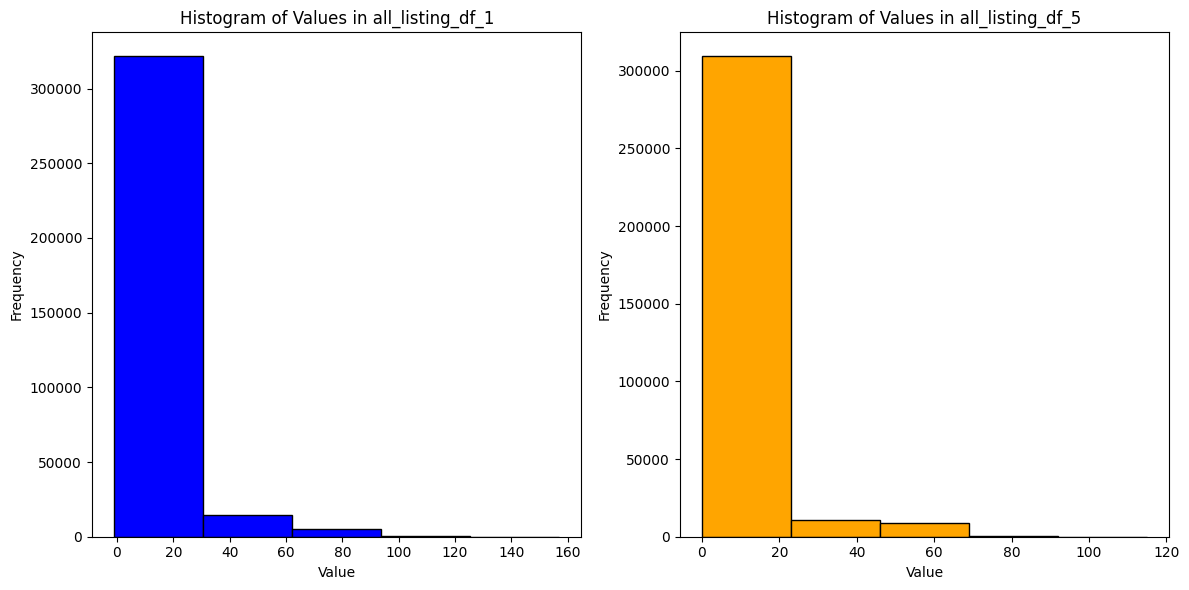

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

temp_df_1 = all_listing_df_1.copy()
temp_df_5 = all_listing_df_5.copy()

# Factorize 'property_type' for temporary DataFrames
temp_df_1['property_type'] = pd.factorize(temp_df_1['property_type'])[0]
temp_df_5['property_type'] = pd.factorize(temp_df_5['property_type'])[0]

plt.figure(figsize=(12, 6))

# Plot the histogram of 'property_type' in all_listing_df_1
plt.subplot(1, 2, 1)
temp_df_1['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_1')

# Plot the histogram of 'property_type' in all_listing_df_5
plt.subplot(1, 2, 2)
temp_df_5['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
all_listing_df_5["room_type"].value_counts()

room_type
Entire home/apt    241127
Private room        84659
Shared room          3788
Name: count, dtype: int64

Now, we are going to check that there are no erros in availability (e.g. that no property is available for more than 30 days per month)

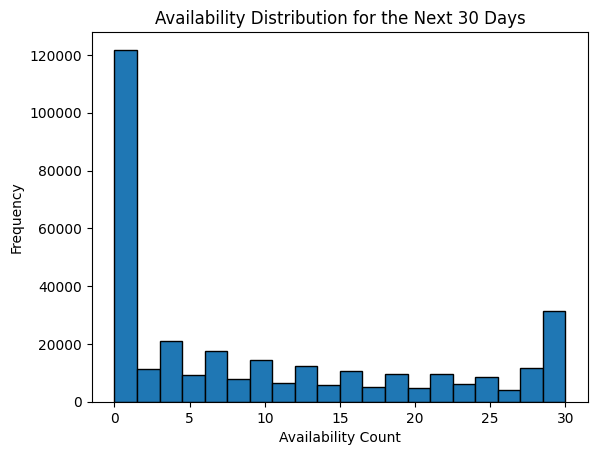

In [18]:
import matplotlib.pyplot as plt

plt.hist(all_listing_df_5["availability_30"], bins=20, edgecolor='black')  
plt.title("Availability Distribution for the Next 30 Days")
plt.xlabel("Availability Count")
plt.ylabel("Frequency")
plt.show()


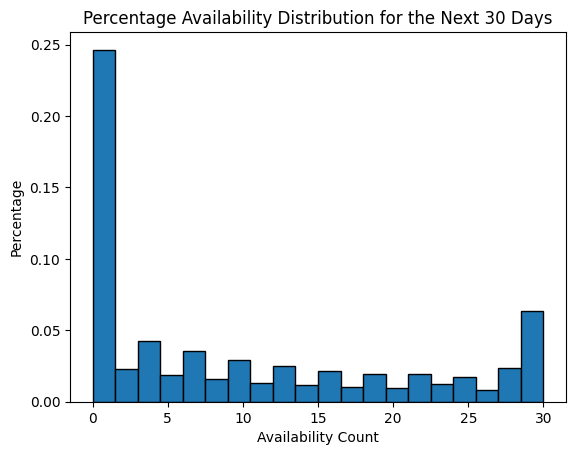

In [19]:
import matplotlib.pyplot as plt

# Assuming all_listing_df_5 is your DataFrame
plt.hist(all_listing_df_5["availability_30"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage Availability Distribution for the Next 30 Days")
plt.xlabel("Availability Count")
plt.ylabel("Percentage")
plt.show()


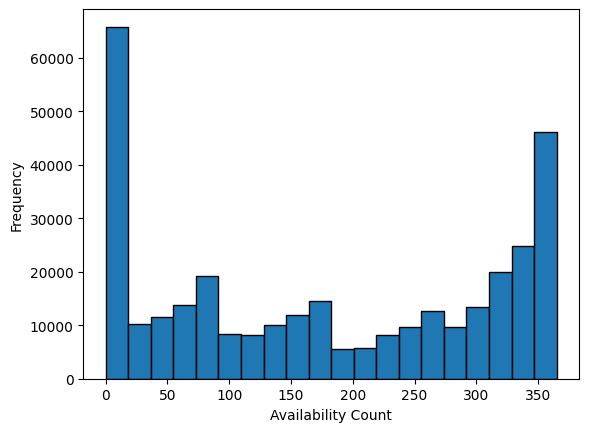

In [20]:
import matplotlib.pyplot as plt
plt.hist(all_listing_df_5["availability_365"], bins=20, edgecolor='black')  
plt.xlabel("Availability Count")
plt.ylabel("Frequency")
plt.show()


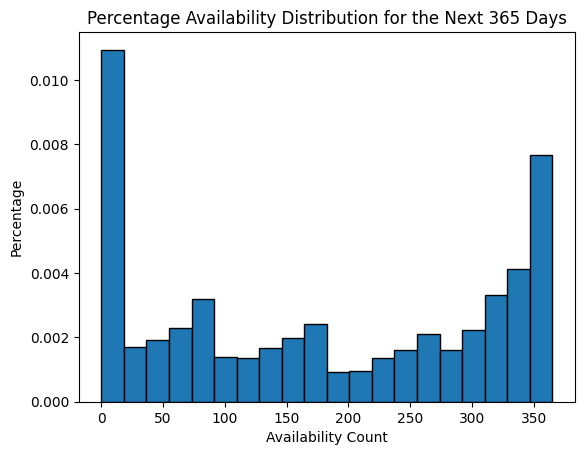

In [21]:
import matplotlib.pyplot as plt

# Assuming all_listing_df_5 is your DataFrame
plt.hist(all_listing_df_5["availability_365"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage Availability Distribution for the Next 365 Days")
plt.xlabel("Availability Count")
plt.ylabel("Percentage")
plt.show()


Since we focus on properties that are going to be rented out for short term stays (targeting tourists) we will now look at the minimum_nights column, and remove all properties that have a high requested minimum_nights (since these would be long term stays)

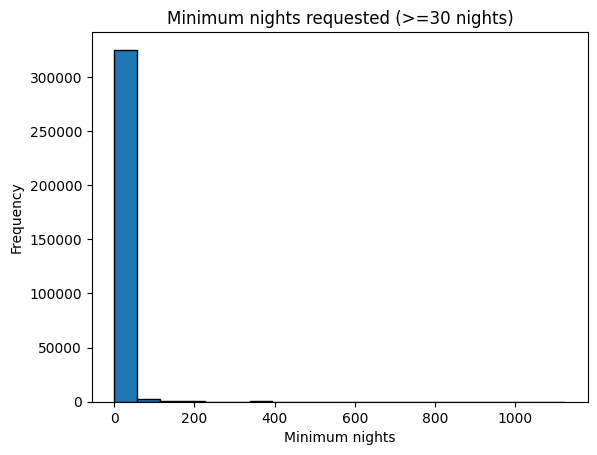

In [22]:
import matplotlib.pyplot as plt

plt.hist(all_listing_df_5["minimum_nights"], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Minimum nights requested (>=30 nights)")
plt.xlabel("Minimum nights")
plt.ylabel("Frequency")
plt.show()

##we can see that there are minimum nights close to 400 nights


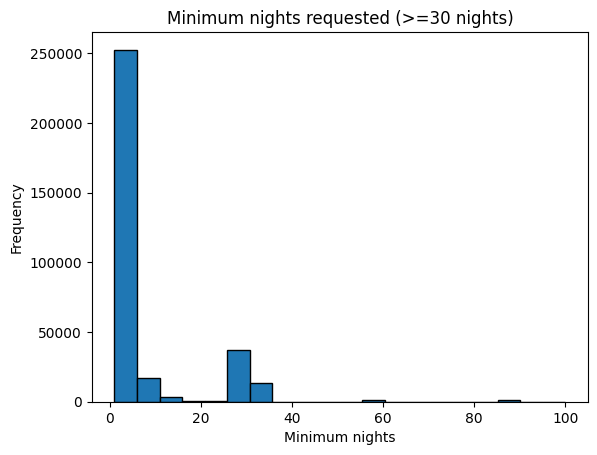

In [23]:
import matplotlib.pyplot as plt
filtered_df = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 100]

plt.hist(filtered_df["minimum_nights"], bins=20, edgecolor='black') 
plt.title("Minimum nights requested (>=30 nights)")
plt.xlabel("Minimum nights")
plt.ylabel("Frequency")
plt.show()


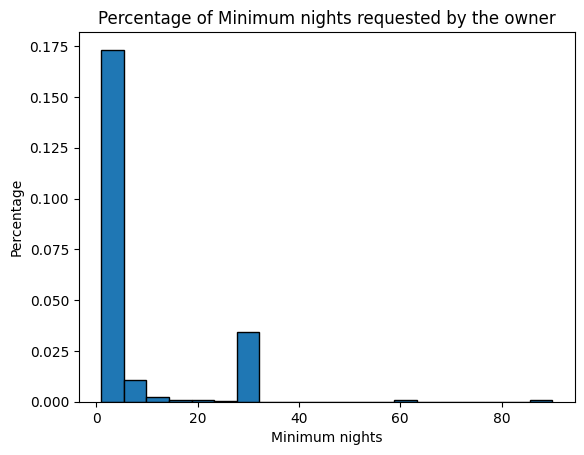

In [24]:
# Assuming all_listing_df_5 is your DataFrame
filtered_df = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 90]
plt.hist(filtered_df["minimum_nights"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage of Minimum nights requested by the owner")
plt.xlabel("Minimum nights")
plt.ylabel("Percentage")
plt.show()

In [25]:
# Assuming all_listing_df_5 is your DataFrame

all_listing_df_5["minimum_nights"] = all_listing_df_5["minimum_nights"].astype(int)

counts = all_listing_df_5["minimum_nights"].value_counts(bins=range(0, max(all_listing_df_5["minimum_nights"]) + 31, 30))

# Calculate the percentage column
percentage_column = (counts / len(all_listing_df_5)) * 100

# Create a new DataFrame with counts and percentage_column
result_df = pd.DataFrame({'Counts': counts, 'Percentage': percentage_column})

# Print or display the result DataFrame
print(result_df)


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/2514485738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_listing_df_5["minimum_nights"] = all_listing_df_5["minimum_nights"].astype(int)


                  Counts  Percentage
minimum_nights                      
(-0.001, 30.0]    311353   94.471348
(30.0, 60.0]       14718    4.465765
(60.0, 90.0]        1364    0.413868
(90.0, 120.0]        532    0.161421
(150.0, 180.0]       499    0.151408
(360.0, 390.0]       474    0.143822
(180.0, 210.0]       125    0.037928
(120.0, 150.0]       118    0.035804
(270.0, 300.0]       110    0.033376
(330.0, 360.0]        77    0.023363
(990.0, 1020.0]       58    0.017598
(480.0, 510.0]        32    0.009710
(1110.0, 1140.0]      26    0.007889
(240.0, 270.0]        24    0.007282
(210.0, 240.0]        23    0.006979
(570.0, 600.0]         7    0.002124
(720.0, 750.0]         6    0.001821
(690.0, 720.0]         6    0.001821
(390.0, 420.0]         6    0.001821
(300.0, 330.0]         6    0.001821
(780.0, 810.0]         4    0.001214
(420.0, 450.0]         2    0.000607
(930.0, 960.0]         1    0.000303
(1080.0, 1110.0]       1    0.000303
(450.0, 480.0]         1    0.000303
(

We can see that more than 98% of all properties have requested a minimum stay of below 60. Therefore it makes sense to remove anything with minimum_nights requested above 60.  

In [26]:
# Assuming all_listing_df_5 is your DataFrame
all_listing_df_6 = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 60]

#Display the filtered DataFrame
all_listing_df_6


,id,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,location
1,86645.0,Entire rental unit,Entire home/apt,3.0,$184.00,1,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,$200.00,3,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,$60.00,5,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,$200.00,3,6.0,29.0,364.0,Zurich
5,222565.0,Private room in home,Private room,3.0,$69.00,2,30.0,0.0,208.0,Zurich
...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,$265.00,21,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,$31.00,5,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,$90.00,3,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,$112.00,3,1125.0,0.0,0.0,Malaga


## Pricing Analysis

GABRIEL'S CODE IS PASTED BELOW:

In [27]:
#PLEASE CHECK IF THIS WORKS AND MAKES SENSE (i don't have enough ram in my laptop to concatenate the original dataframes ☠)

# WHEN RUNNING THIS, HAVE TO FIRST ADD BACK BEDS AND BEDROOMS TO THE DATA FRAME (AKA REMOVE THEM FROM THE "DROP" THING)
'''

# Plot distribution of prices
plt.figure(figsize=(12, 6))
sns.histplot(all_listing_df_6['price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of prices by country
plt.figure(figsize=(14, 6))
sns.boxplot(x='region_name', y='price', data=all_listing_df_6)
plt.title('Distribution of Prices by Country')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate price per bedroom and price per bed
all_listing_df_6['price_per_bedroom'] = all_listing_df_6['price'] / all_listing_df_6['bedrooms']
all_listing_df_6['price_per_bed'] = all_listing_df_6['price'] / all_listing_df_6['beds']

# Plot distribution of price per bedroom and price per bed
plt.figure(figsize=(12, 6))
sns.histplot(all_listing_df_6['price_per_bedroom'], bins=30, kde=True, label='Price per Bedroom')
sns.histplot(all_listing_df_6['price_per_bed'], bins=30, kde=True, label='Price per Bed')
plt.title('Distribution of Price per Bedroom and Price per Bed')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot distribution of price per bedroom and price per bed by country
plt.figure(figsize=(14, 6))
sns.boxplot(x='region_name', y='price_per_bedroom', data=all_listing_df_6, label='Price per Bedroom')
sns.boxplot(x='region_name', y='price_per_bed', data=all_listing_df_6, label='Price per Bed')
plt.title('Distribution of Price per Bedroom and Price per Bed by Country')
plt.xlabel('Country')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

'''

"\n\n# Plot distribution of prices\nplt.figure(figsize=(12, 6))\nsns.histplot(all_listing_df_6['price'], bins=30, kde=True)\nplt.title('Distribution of Prices')\nplt.xlabel('Price')\nplt.ylabel('Frequency')\nplt.show()\n\n# Plot distribution of prices by country\nplt.figure(figsize=(14, 6))\nsns.boxplot(x='region_name', y='price', data=all_listing_df_6)\nplt.title('Distribution of Prices by Country')\nplt.xlabel('Country')\nplt.ylabel('Price')\nplt.xticks(rotation=45, ha='right')\nplt.show()\n\n# Calculate price per bedroom and price per bed\nall_listing_df_6['price_per_bedroom'] = all_listing_df_6['price'] / all_listing_df_6['bedrooms']\nall_listing_df_6['price_per_bed'] = all_listing_df_6['price'] / all_listing_df_6['beds']\n\n# Plot distribution of price per bedroom and price per bed\nplt.figure(figsize=(12, 6))\nsns.histplot(all_listing_df_6['price_per_bedroom'], bins=30, kde=True, label='Price per Bedroom')\nsns.histplot(all_listing_df_6['price_per_bed'], bins=30, kde=True, label=

UPDATED CODE BELOW:

We want to see the distribution of property prices throughout the listings data set to see if there are any obvious outliers.

For simplicity, we will calculate the price per person accomodated in each property. This is because it allows us to understand how much each person in the property pays, and thus allows investors looking to buy a property to rent on Airbnb to know how much an average guest will pay them for a night in their property. Additionally, the investor can then decide based on their budget how many guests their property should accomodate (aka how big should the property be for the revenue they want to achieve). 


In [28]:
# make a new data frame
all_listing_df_7 = all_listing_df_6.copy()

# convert price column from an object to a float (also by removing the dollar sign)
all_listing_df_7['price'] = all_listing_df_7['price'].str.replace(',', '').str.replace('$', '')
all_listing_df_7['price'] = pd.to_numeric(all_listing_df_7['price'], errors='coerce')

all_listing_df_7


,id,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,location
1,86645.0,Entire rental unit,Entire home/apt,3.0,184.0,1,9999.0,0.0,0.0,Zurich
2,143821.0,Entire loft,Entire home/apt,2.0,200.0,3,365.0,0.0,145.0,Zurich
3,178448.0,Private room in rental unit,Private room,1.0,60.0,5,31.0,0.0,221.0,Zurich
4,204586.0,Private room in rental unit,Private room,1.0,200.0,3,6.0,29.0,364.0,Zurich
5,222565.0,Private room in home,Private room,3.0,69.0,2,30.0,0.0,208.0,Zurich
...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,265.0,21,60.0,0.0,0.0,Malaga
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,31.0,5,1125.0,3.0,3.0,Malaga
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,90.0,3,1125.0,0.0,2.0,Malaga
342234,50607554.0,Tiny home,Entire home/apt,4.0,112.0,3,1125.0,0.0,0.0,Malaga


In [29]:
# next, let's conver the currencies. The data set has 6 currencies: Euros, Swiss franks, mexican pesos, US dollars, Canadian dollars and the
# Japanese Yen. We will keep the currencies in Euros because most properties are in Euros

# make a numpy array with the currency conversion rate in the order specified below (excluding Euro):

currency_convert = np.array([1.05, 0.052, 0.92, 0.67, 0.0062]) # Swiss frank, mexican peso, US dollar, Canadian dollar, Japanese Yen


US_locations = ["Los Angeles", "San Diego", "San Francisco", "Washington"]
Canada_locations = ["Toronto", "Vancouver", "Winnipeg"]
Swiss_locations = ["Geneva","Zurich"]
Japan_locations = ["Tokyo"]
Mexico_locations = ["Mexico City"]

# make a new column for the prices in euros
all_listing_df_7["Euro_price"] = 0  # for now make the column only zeroes, will be edited later

# convert the price_per_guest to Euros
for location in all_listing_df_7["location"].unique():
    if location in Swiss_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[0]
    elif location in Mexico_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[1]
    elif location in US_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[2]
    elif location in Canada_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[3]
    elif location in Japan_locations:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"] * currency_convert[4]
    else:
        all_listing_df_7.loc[all_listing_df_7['location'] == location, "Euro_price"] = all_listing_df_7.loc[all_listing_df_7['location'] == location, "price"]

# round the prices to two decial points
all_listing_df_7["Euro_price"] = round(all_listing_df_7["Euro_price"],2)

# calculate price per guest of each property (note that this is still in the location currency)
all_listing_df_7["price_per_guest"] = round(all_listing_df_7["Euro_price"]/all_listing_df_7["accommodates"],2)

# show the dataframe
all_listing_df_7


,id,property_type,room_type,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,location,Euro_price,price_per_guest
1,86645.0,Entire rental unit,Entire home/apt,3.0,184.0,1,9999.0,0.0,0.0,Zurich,193.20,64.40
2,143821.0,Entire loft,Entire home/apt,2.0,200.0,3,365.0,0.0,145.0,Zurich,210.00,105.00
3,178448.0,Private room in rental unit,Private room,1.0,60.0,5,31.0,0.0,221.0,Zurich,63.00,63.00
4,204586.0,Private room in rental unit,Private room,1.0,200.0,3,6.0,29.0,364.0,Zurich,210.00,210.00
5,222565.0,Private room in home,Private room,3.0,69.0,2,30.0,0.0,208.0,Zurich,72.45,24.15
...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,Entire rental unit,Entire home/apt,6.0,265.0,21,60.0,0.0,0.0,Malaga,265.00,44.17
342232,32705544.0,Entire rental unit,Entire home/apt,2.0,31.0,5,1125.0,3.0,3.0,Malaga,31.00,15.50
342233,33294303.0,Entire rental unit,Entire home/apt,4.0,90.0,3,1125.0,0.0,2.0,Malaga,90.00,22.50
342234,50607554.0,Tiny home,Entire home/apt,4.0,112.0,3,1125.0,0.0,0.0,Malaga,112.00,28.00


In [30]:
# Find the largest value in the price_per_guest column

all_listing_df_7["price_per_guest"].max()

99149.0

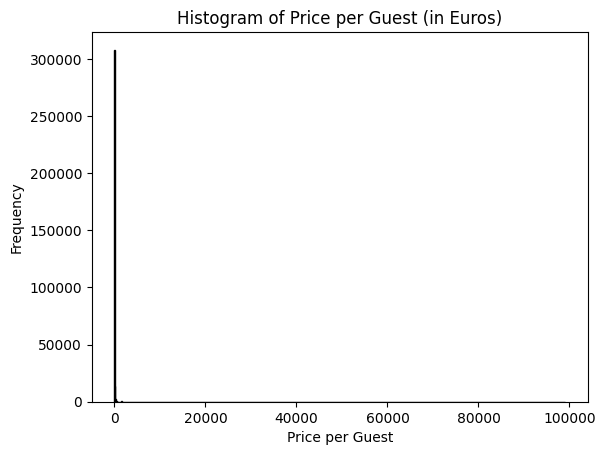

In [31]:
# now, we can plot the distribution of the prices per guest to detect any outliers

# Since the maximal value is so high, we will account for it in the histogram for now. For clarity and run time, we will use bins of width 100
plt.hist(all_listing_df_7['price_per_guest'], bins=range(0, 99150, 100), edgecolor='black')  # bins of 100 values (easier to see)
plt.xlabel('Price per Guest')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Guest (in Euros)')
plt.show()

In [32]:
# This is clearly inefficient since pretty much all of the data is much lower. We will thus plot a histogram with only data within the 
# bottom 99% percentile

percentile_threshold = 0.99

# Calculate the threshold value
threshold_value = all_listing_df_7['price_per_guest'].quantile(percentile_threshold)

# Filter the DataFrame to include only values within the bottom 95% percentile
all_listing_df_8 = all_listing_df_7[all_listing_df_7['price_per_guest'] <= threshold_value]

all_listing_df_8["price_per_guest"].max()


250.0

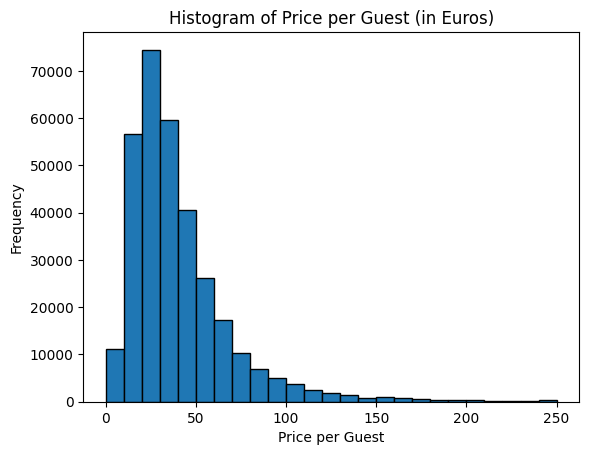

In [33]:

# plot the new histogram:
plt.hist(all_listing_df_8['price_per_guest'], bins=range(0, 260, 10), edgecolor='black')  # bins of 10 values (arbitrary value, just for us to see the distirbution clearly)
plt.xlabel('Price per Guest')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Guest (in Euros)')
plt.show()


In [34]:
# This still seems like too big of a distribution. Considering that we are assuming that our investor has a fairly average budget, it is 
# unlikley that they will be able to afford to buy a property that is expensive enough to be worth more than around 100 euros per night per 
# person. As such, we will narrow down our values such that we only use values in the bottom 95% percentile.

percentile_threshold = 0.95

# Calculate the threshold value
threshold_value = all_listing_df_7['price_per_guest'].quantile(percentile_threshold)

# Filter the DataFrame to include only values within the bottom 95% percentile
all_listing_df_8 = all_listing_df_7[all_listing_df_7['price_per_guest'] <= threshold_value]

all_listing_df_8["price_per_guest"].max()


102.96

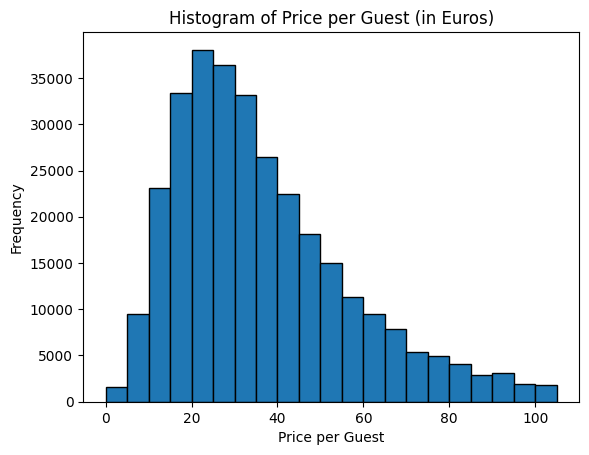

In [35]:
# plot the new histogram:

# note that here we will use bins of width 5, simply because it makes the data cleaner and easier to read. Additionally, it is unrealistic
# that when buying a property the investor knows exactly how much he will be charging per room; it is more likley that they will have a 
# rough idea of the price range. Hence, using bins > 1 makes sense. 

plt.hist(all_listing_df_8['price_per_guest'], bins=range(0, 110, 5), edgecolor='black')  # bins of 5 values 
plt.xlabel('Price per Guest')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Guest (in Euros)')
plt.show()



As such, the final data frame with all suitable property listings is all_listing_df_8

## Consistency Analysis

### Creating dataset for average avaliability of listings per month per city

In [36]:

## add code that checks for the id 

def load_rental_data(city_name):
    """
    Load rental data for a specific city from a subdirectory.
    
    Parameters:
    - city_name (str): The name of the city.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    # Construct the directory path based on the city name
    directory_path = f"home_rentals/{city_name}"
    
    # Assuming the file is named 'calendar.csv.gz'
    file_path = f"{directory_path}/calendar.csv.gz"
    
    try:
        # Load the DataFrame from the specified file
        df = pd.read_csv(file_path, compression='gzip')
        
        # You can perform additional processing on the DataFrame if needed
        
        # Return the loaded DataFrame
        return df
    except FileNotFoundError:
        # Handle the case where the file is not found
        print(f"Data not found for {city_name}. Check the directory path and file name.")
        return None
    

def filter_ids(df1, df2):
    """
    Filter out ID values in df1 that are not available in df2.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame.
    - df2 (pd.DataFrame): The second DataFrame.
    - id_column (str): The column containing the ID values.

    Returns:
    - pd.DataFrame: The filtered DataFrame.
    """
    id_column = "id"
    filtered_df = df1[df1["listing_id"].isin(df2["id"])]
    return filtered_df



def averageavaliability(city, latest_df):

    cityname = city
    citydata = load_rental_data(cityname) 

    #filter our ID's that are NOT present in our cleaned all_listings 

    filtered_citydata = filter_ids(citydata, latest_df)
    
    filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
    filtered_citydata["month"] = filtered_citydata["date"].dt.month
    filtered_citydata["year"] = filtered_citydata["date"].dt.year
    filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)

    # make a new data frame
    ave_month = (filtered_citydata[filtered_citydata['available'] == 't'].groupby(['listing_id', 'month_year']).size().unstack(fill_value=0).stack().reset_index(name='days_available'))
    
    # Calculate the average days_available for each month_year (making sure that it rounds to full numbers)
    ave_month = (ave_month.groupby('month_year')['days_available'].mean().round(0).reset_index(name='average_days_available'))
    # convert the month_year column to datetime format 
    ave_month['month_year'] = pd.to_datetime(ave_month['month_year'], format='%m-%Y').dt.to_period('M')

    # sort the rows by ascending dates
    ave_month = ave_month.sort_values('month_year')

    # reset the row index
    ave_month.reset_index(drop=True, inplace=True)

    ave_month['location'] = city

    return ave_month




In [37]:
# Will take 10 mins to run but it WORKSSSSSS SLAY

all_locations = all_listing_df_8["location"].unique()

average_by_month = pd.DataFrame()

for location in all_locations:
    ave_month = averageavaliability(location, all_listing_df_8)
    average_by_month = pd.concat([average_by_month, ave_month], axis=0)
    print(location)


    

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Zurich


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Barcelona


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Milan


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Valencia


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Mallorca


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Washington


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Rotterdam


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Tokyo


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Los Angeles


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Lisbon


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Ireland


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Mexico City
Madrid


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Geneva


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Euskadi


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Vienna


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Vancouver


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

San Diego


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Menorca


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Naples


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Toronto


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

San Francisco


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Winnipeg


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Rome


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Malta


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Amsterdam


/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3489930091.py:62: SettingWithCopyWarning: 
A value is t

Malaga


In [38]:
# note that all of the properties in Madrid have no listing ID in the listings data file. Thus, we cannot merge the calendar and the listings
# data for the city because we do not have the corresponding IDs. As such, the function removed all of the Madrid properties. 

average_by_month["location"].unique()

array(['Zurich', 'Barcelona', 'Milan', 'Valencia', 'Mallorca',
       'Washington', 'Rotterdam', 'Tokyo', 'Los Angeles', 'Lisbon',
       'Ireland', 'Mexico City', 'Geneva', 'Euskadi', 'Vienna',
       'Vancouver', 'San Diego', 'Menorca', 'Naples', 'Toronto',
       'San Francisco', 'Winnipeg', 'Rome', 'Malta', 'Amsterdam',
       'Malaga'], dtype=object)

### Correcting for additional months

In [39]:
# check for the unique "month_year" vaues in the average_by_month dataframe. This allows us to see what months are covered by the data
average_by_month["month_year"].unique()


<PeriodArray>
['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10']
Length: 14, dtype: period[M]

In [40]:
# All of the locations should have data from 2022-09 until 2023-09. From above, we see that some locations also have 2023-10
# loop through the dataframe and remove observations in 2023-10 for any locations that may have them

# Create a boolean mask based on the specified conditions
mask = average_by_month['month_year'] == "2023-10"

# Use the boolean mask to filter the DataFrame and keep only the rows that don't match the conditions
average_by_month = average_by_month[~mask]

# check that we got the result we wanted
average_by_month["month_year"].value_counts()



month_year
2022-09    26
2022-10    26
2022-11    26
2022-12    26
2023-01    26
2023-02    26
2023-03    26
2023-04    26
2023-05    26
2023-06    26
2023-07    26
2023-08    26
2023-09    26
Freq: M, Name: count, dtype: int64

### Seasonality Analysis

Next, we will look at the seasonality of each month for each location, comparing it between the locations and calculating a seasonality index. We do this so as to have an idea of how consistent the bookings are per month for each location.

In [41]:
# Calculate the seasonality index for each month of each location

# find the average availability per month between all locations
seasonality_df = average_by_month
seasonality_df['Average'] = seasonality_df.groupby('month_year')['average_days_available'].transform('mean')

# calculate the seasonality index for each location's month and append it to the dataframe 
seasonality_df['Seasonality_Index_%'] = round((seasonality_df['average_days_available'] / seasonality_df['Average']) * 100,1)

# remove the Average column since it is no longer needed
#seasonality_df = seasonality_df.drop("Average", axis=1)

# show the data frame 
seasonality_df




,month_year,average_days_available,location,Average,Seasonality_Index_%
0,2022-09,1.0,Zurich,3.769231,26.5
1,2022-10,10.0,Zurich,14.423077,69.3
2,2022-11,14.0,Zurich,18.653846,75.1
3,2022-12,16.0,Zurich,19.153846,83.5
4,2023-01,17.0,Zurich,19.384615,87.7
...,...,...,...,...,...
8,2023-05,17.0,Malaga,16.807692,101.1
9,2023-06,17.0,Malaga,15.653846,108.6
10,2023-07,16.0,Malaga,15.615385,102.5
11,2023-08,16.0,Malaga,15.846154,101.0


The seasonality index indicates how the availability per month of each location varies with respect to a seasonal pattern. A seasonality index value above 100% indicates a period of higher demand or availability compared to the average. A seasonality index value below 100%, instead, indicates a period of lower demand or availability compared to the average. Finally, a seasonality index of 100% suggests that the availability is in line with the average, without any significant seasonal deviation.

In order to visualise the above results better, we will generate a bar graph for each location showing the average days available and the seasonality of each month in the location. In this way, we can get a better idea of the actual days of availability per month in each location, and how this value compares with other locations (we see this via the seasonality index).

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


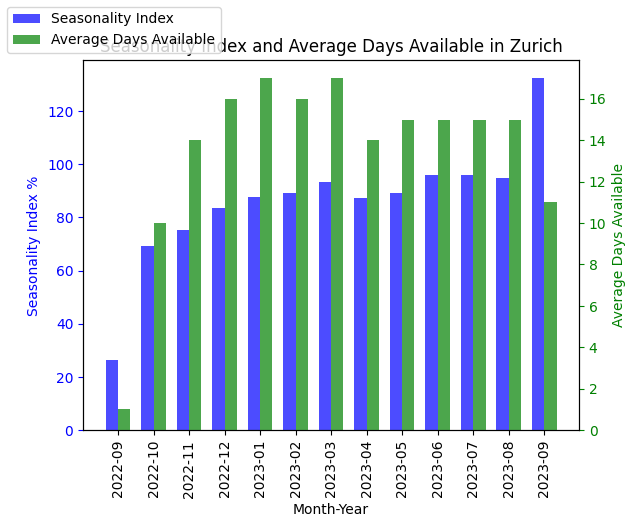

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


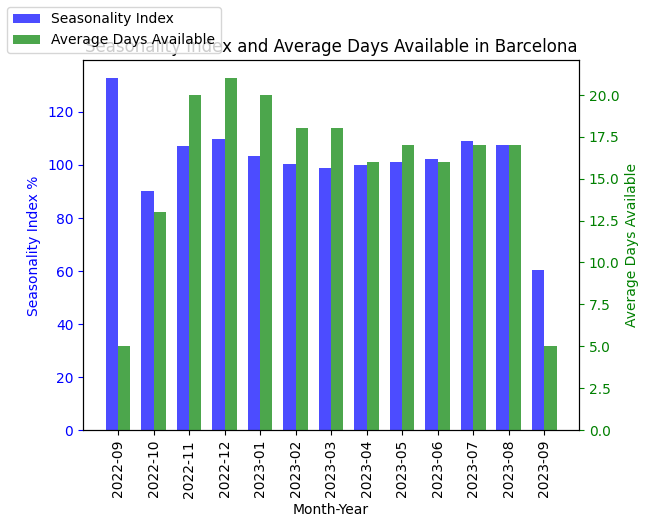

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


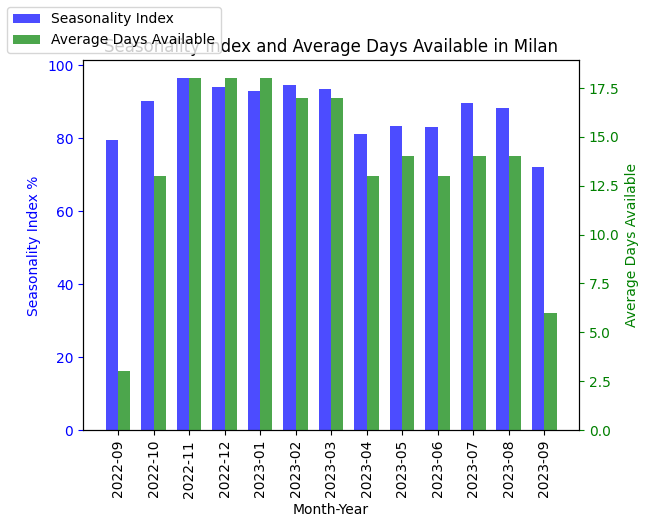

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


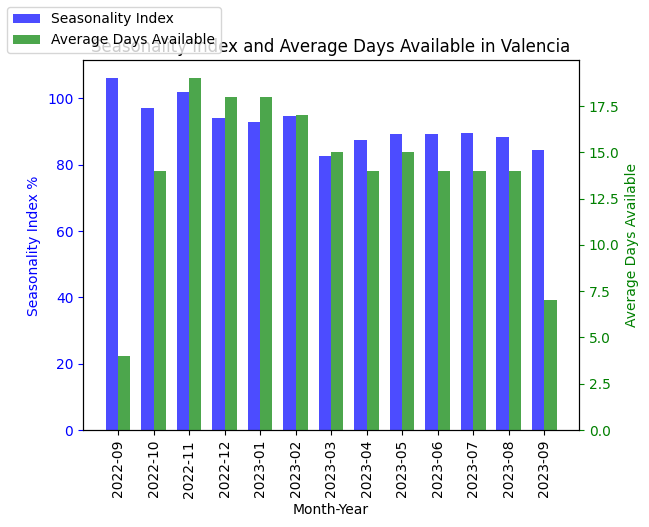

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


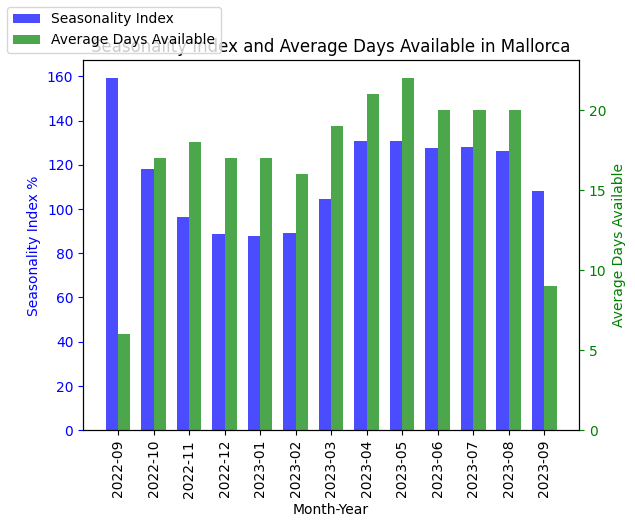

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


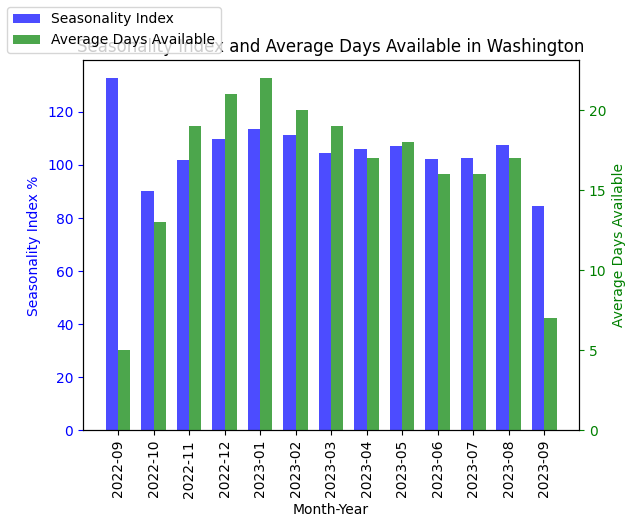

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


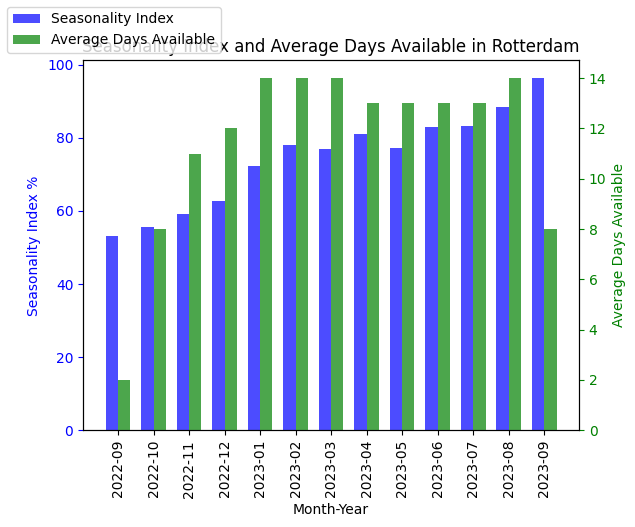

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


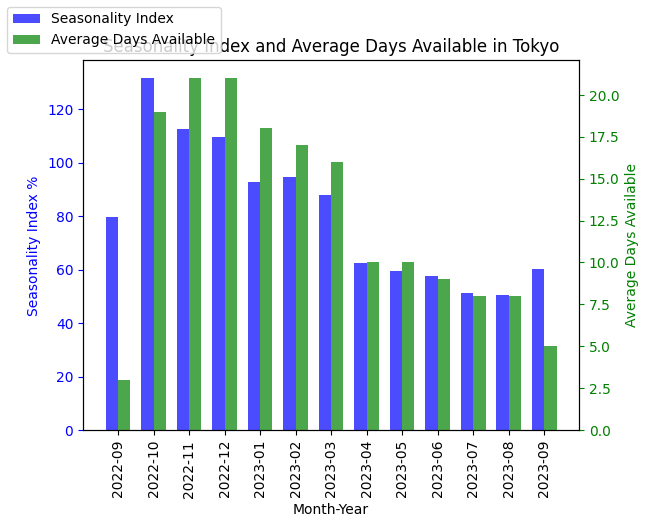

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


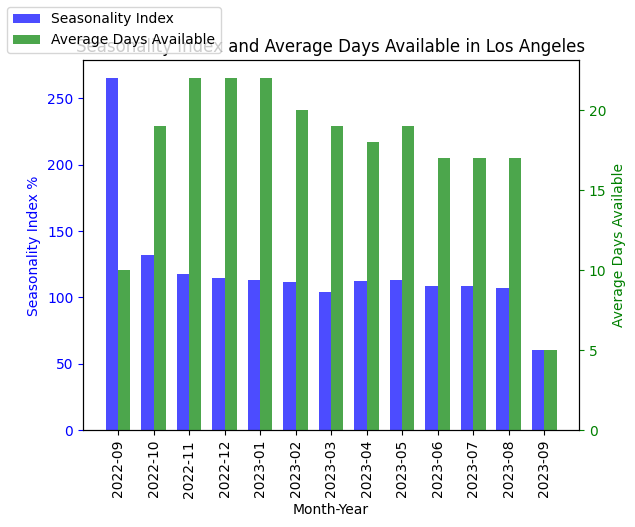

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


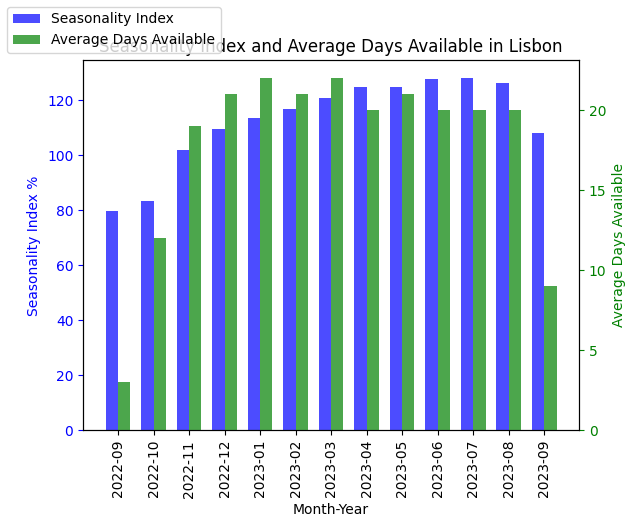

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


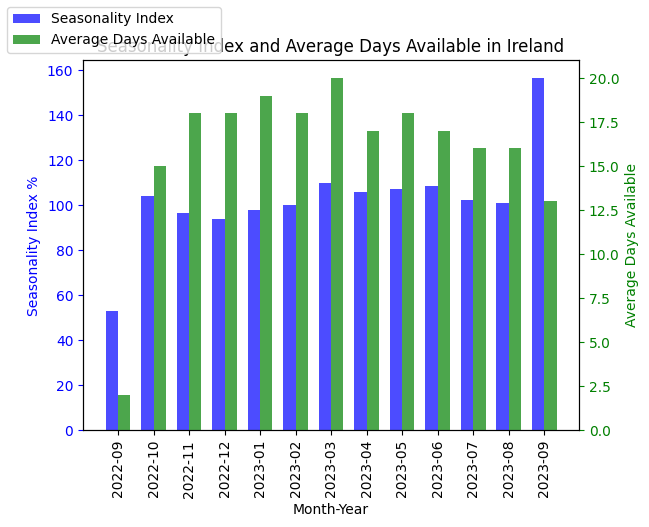

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


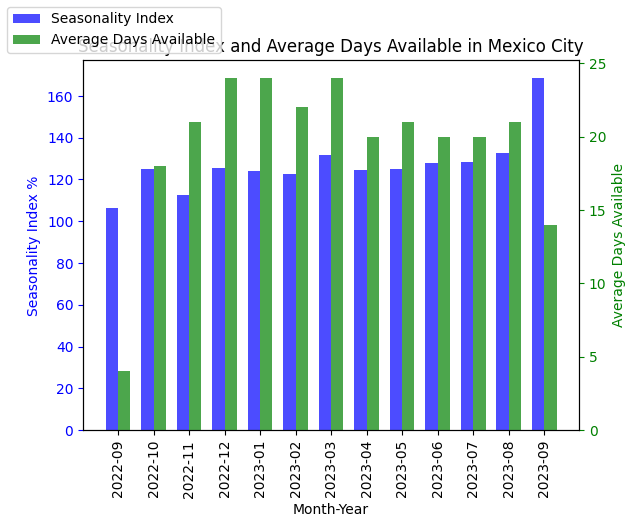

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


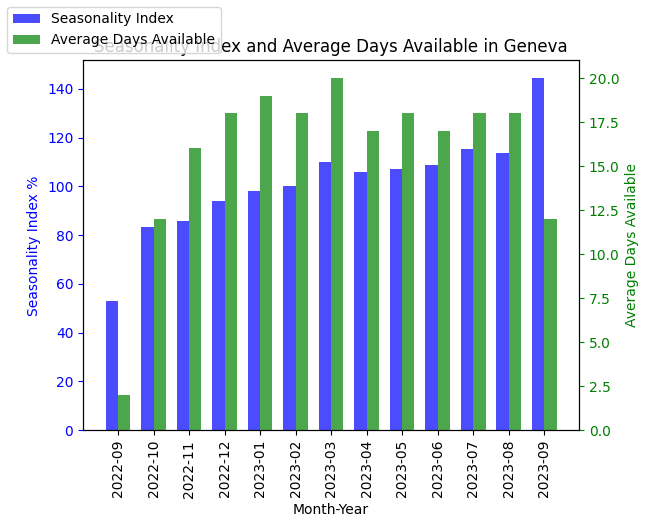

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


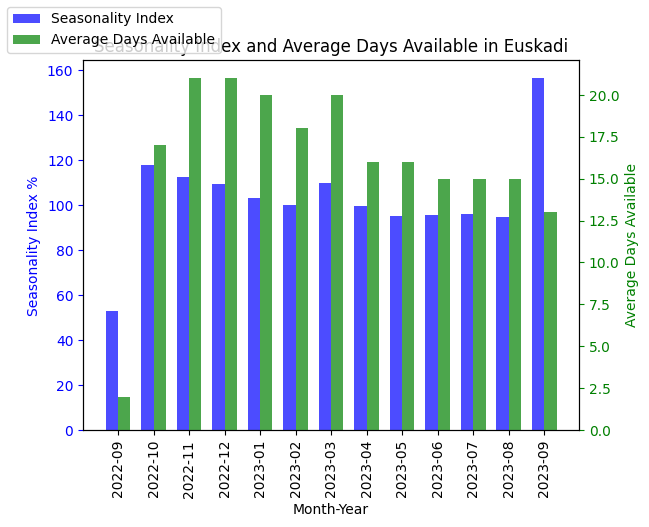

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


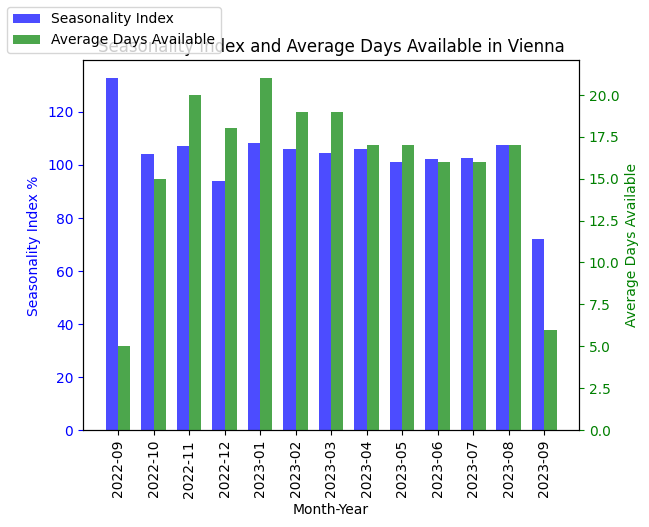

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


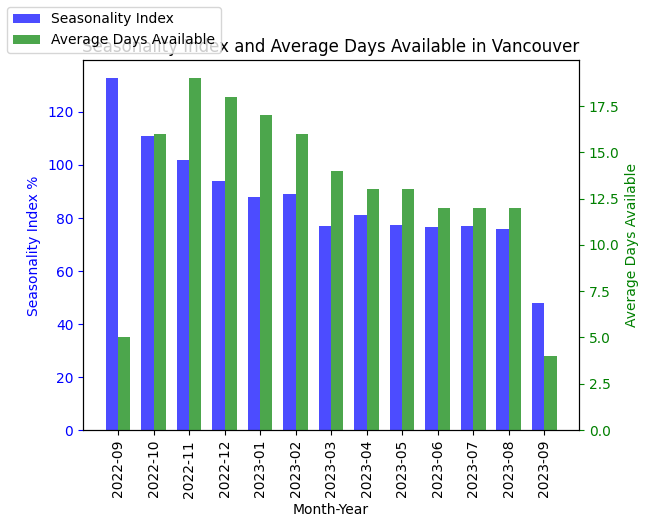

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


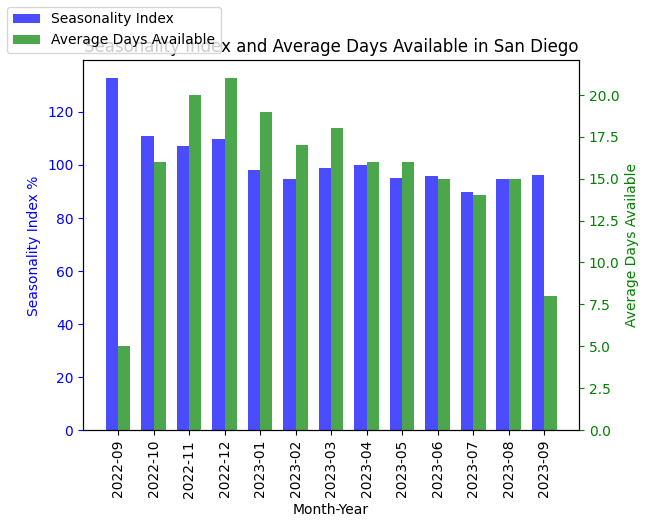

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


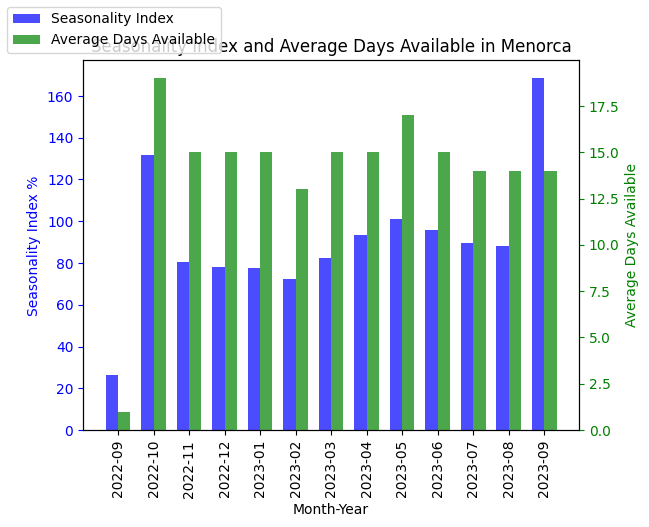

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


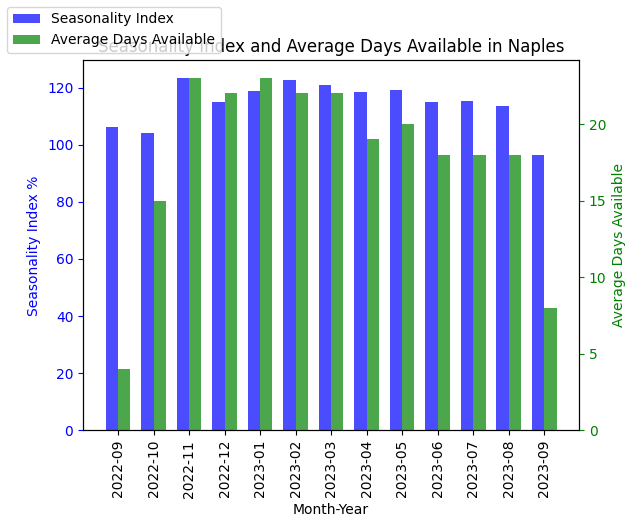

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


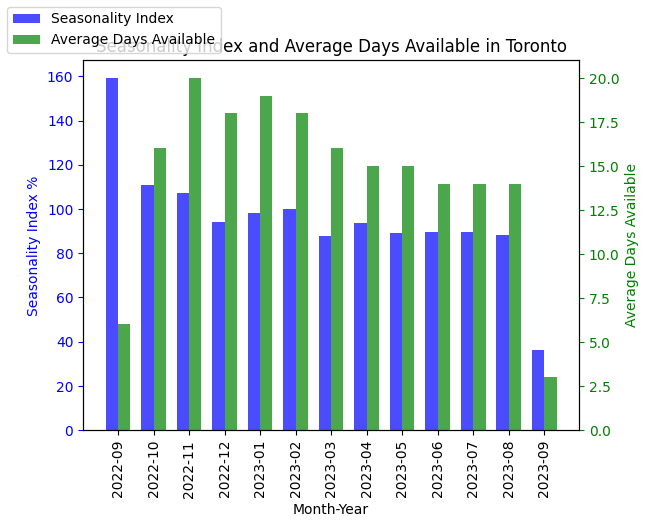

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


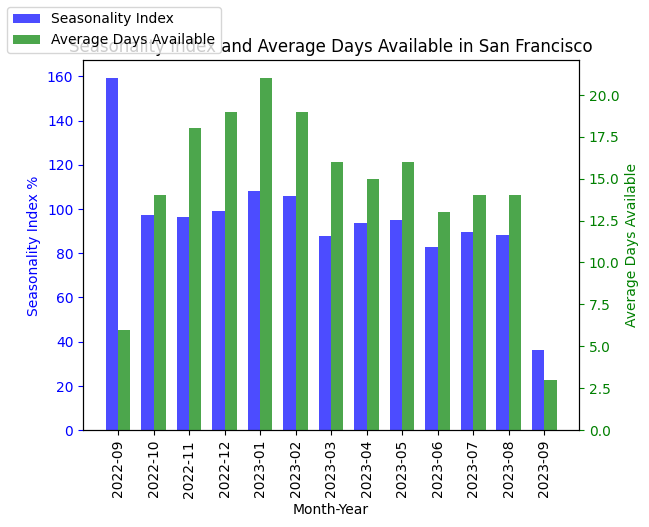

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


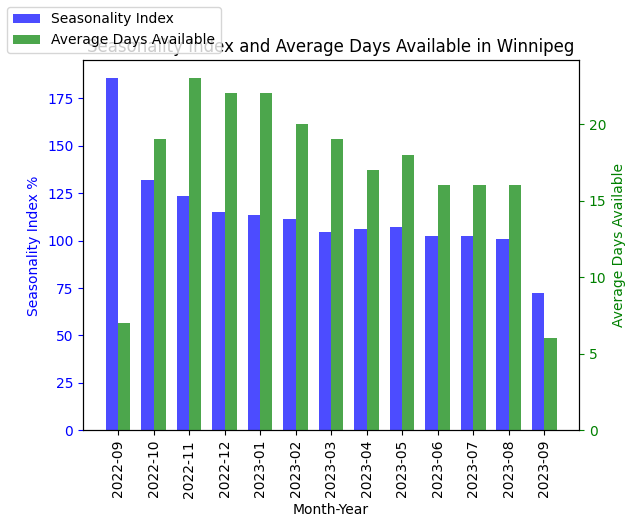

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


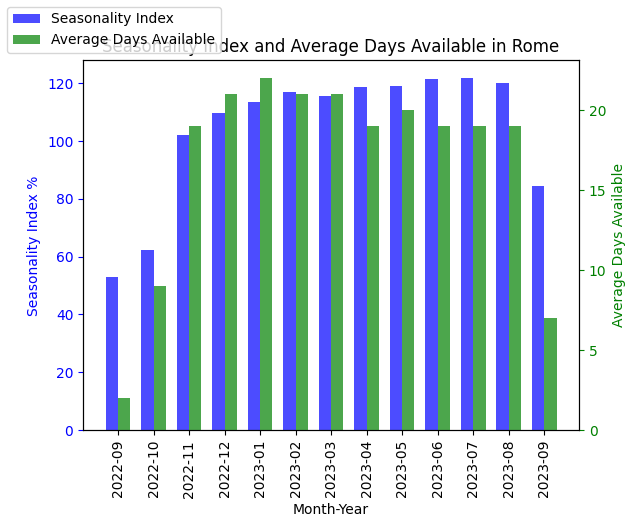

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


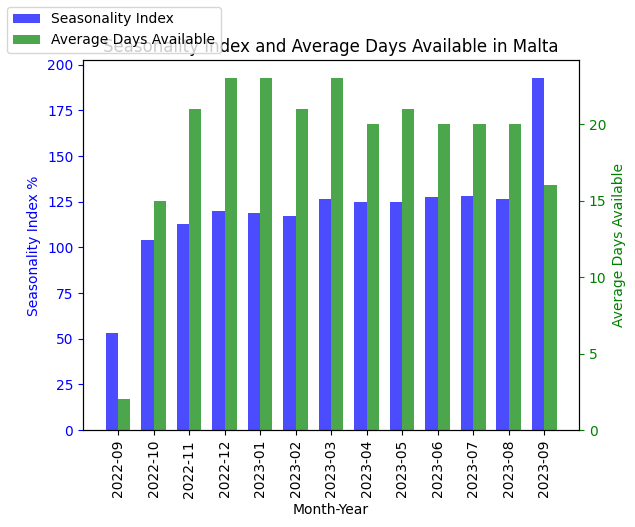

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


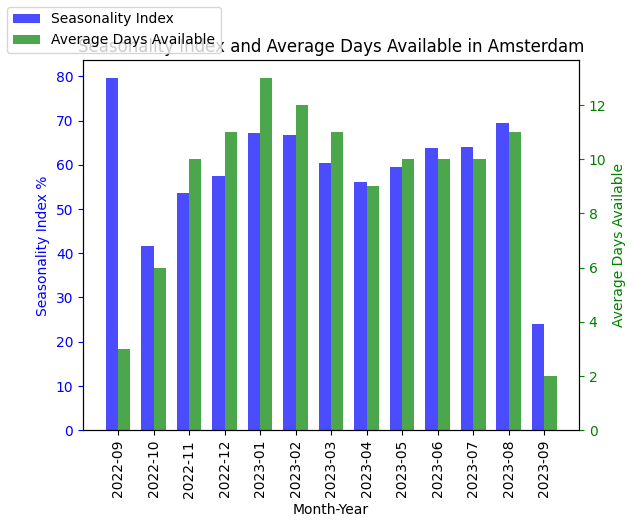

/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
/var/folders/35/frswy9yj13g0v2drzlm9gqfc0000gn/T/ipykernel_13581/3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


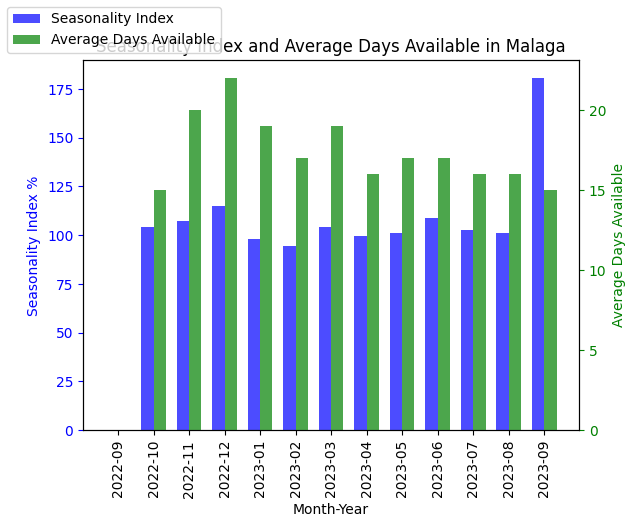

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the monthly availability and seasonality index for each location

all_the_locations = average_by_month["location"].unique()

# Set the width of the bars
bar_width = 0.35

# Make the bar charts
for location in all_the_locations:

    season_given_location = seasonality_df[seasonality_df["location"] == location]
    location_name = average_by_month[average_by_month['location'] == location]

    av_si = season_given_location['Seasonality_Index_%']
    av_availability = location_name['average_days_available']

    season_given_location['month_year'] = season_given_location['month_year'].astype(str)
    location_name['month_year'] = location_name['month_year'].astype(str)

    # Create a figure and primary y-axis
    fig, ax1 = plt.subplots()

    # Plot Seasonality Index on the primary y-axis
    ax1.bar(np.arange(len(season_given_location['month_year'])), av_si, width=bar_width, color='blue', alpha=0.7, label='Seasonality Index')
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel('Seasonality Index %', color='blue')
    ax1.tick_params('y', colors='blue')
    ax1.set_title(f'Seasonality Index and Average Days Available in {location}')

    # Create a twin Axes sharing the x-axis
    ax2 = ax1.twinx()

    # Plot Average Days Available on the secondary y-axis
    ax2.bar(np.arange(len(location_name['month_year'])) + bar_width, av_availability, width=bar_width, color='green', alpha=0.7, label='Average Days Available')
    ax2.set_ylabel('Average Days Available', color='green')
    ax2.tick_params('y', colors='green')

    # Set x-axis ticks and labels
    ax1.set_xticks(np.arange(len(season_given_location['month_year'])) + bar_width / 2)
    ax1.set_xticklabels(season_given_location['month_year'], rotation=90)

    # Display the legend
    fig.legend(loc='upper left')

    # Show the plot
    plt.show()


The graphs above allow us to gain a better understanding of the distribution of our data, however there is too much data (and thus it is too specific) for it to be useful when building models. As such, we will calculate a single seasonality index for each location. 

In [43]:
# Calculate the seasonality index for each location

# find the average availability for each locations
seasonality_per_location_df = pd.DataFrame()

seasonality_per_location_df["location"] = average_by_month["location"].unique()

# calculate one average availability per location
for location in all_locations:
    average_avail_per_loc_df = average_by_month.groupby('location')['average_days_available'].mean().reset_index()

# add the average availability of each location to the data frame:
seasonality_per_location_df["average_availability"] = average_avail_per_loc_df["average_days_available"]

# calculate the average availabiity between all locations
average_availbility = average_avail_per_loc_df["average_days_available"].mean()

# calculate the seasonality index for each location and append it to the dataframe 
seasonality_per_location_df['Seasonality_Index_%'] = round((seasonality_per_location_df["average_availability"] / average_availbility) * 100,1)

# show the data frame 
seasonality_per_location_df


,location,average_availability,Seasonality_Index_%
0,Zurich,9.076923,59.1
1,Barcelona,15.615385,101.6
2,Milan,16.076923,104.6
3,Valencia,15.769231,102.6
4,Mallorca,15.923077,103.6
5,Washington,17.692308,115.1
6,Rotterdam,17.461538,113.6
7,Tokyo,16.076923,104.6
8,Los Angeles,17.076923,111.1
9,Lisbon,18.846154,122.6


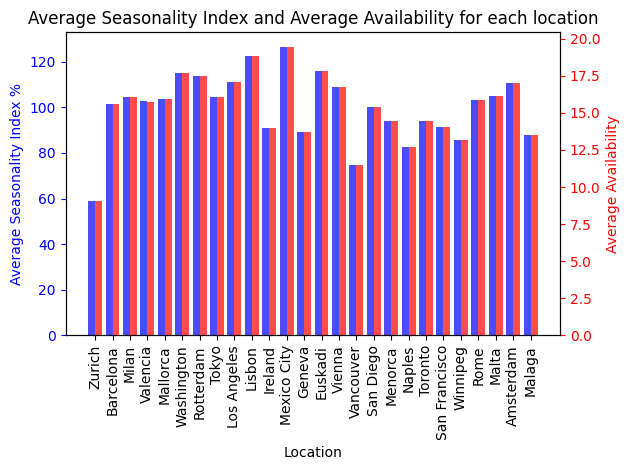

In [44]:
# let's plot the seasonality index and average availability of all locations on one graph:

import matplotlib.pyplot as plt
import numpy as np

# make the bar chart
fig, ax1 = plt.subplots()
bar_width = 0.4
indices = np.arange(len(seasonality_per_location_df['location']))

# plot first axis
ax1.bar(indices - bar_width / 2, seasonality_per_location_df['Seasonality_Index_%'], color='b', alpha=0.7, label='Average Seasonality Index %', width=bar_width)
ax1.set_xlabel('Location')
ax1.set_ylabel('Average Seasonality Index %', color='b')
ax1.set_xticks(indices)
ax1.set_xticklabels(seasonality_per_location_df['location'], rotation=90)  # Rotate x-axis labels vertically
ax1.tick_params('y', colors='b')

# Twin axis for Average Availability on the right axis
ax2 = ax1.twinx()
# Adjust the x-coordinates for the second set of bars
ax2.bar(indices + bar_width / 2, seasonality_per_location_df['average_availability'], color='r', alpha=0.7, label='Average Availability', width=bar_width)
ax2.set_ylabel('Average Availability', color='r')
ax2.tick_params('y', colors='r')

# Title and legend
plt.title('Average Seasonality Index and Average Availability for each location')
fig.tight_layout()
plt.show()

As expected, the average seasonality index and the average availability distributions exactly match each other. This is because, to calculate the seasonality, we are simply taking the average availability of the location and multiplying it by a constant (100 / average availability of data set). 

Although the seasonality index gives us a good insight of the general distribution of availabilities of locations, we have determined that it is superfluous in the context of building our models. This is because the objective of the model is to tell an investor where the best location to buy a property destined to be rented out on Airbnb would be, and thus the investor is not interested in the monthly seasonality of the location, but rather the yearly one (since the property is to be rented out for the whole year). However, since the yearly seasonality index is matched by the average availability of the property, it is easier to simply look at the average availability of the locations and discard the seasonality index. 

# Model generation

## Profitability

First of all, we have to define the metric that we want our models to calculate. In this case, we want the models to tell us what the most profitable location to buy a property to then rent on Airbnb would be. We can calculate profitability by calculating how many nights on average properties in each location are booked per month multiplied by the average price per guest paid per night. 

In [45]:
# first, have to find the average price_per_guest per location

# create the new data frame 
average_ppg_per_location_wM = all_listing_df_8.groupby('location')['price_per_guest'].mean().reset_index(name='average_price_per_guest')

# round the values to 2 decimal places
average_ppg_per_location_wM['average_price_per_guest'] = round(average_ppg_per_location_wM['average_price_per_guest'],2)

# also, have to remember to remove the data for Madrid since the ave_month data frame doesn't have any data for it (as explained earlier)
average_ppg_per_location = average_ppg_per_location_wM[average_ppg_per_location_wM['location'] != "Madrid"]

# reset the index
average_ppg_per_location = average_ppg_per_location.reset_index(drop=True)

# show the new data frame
average_ppg_per_location


,location,average_price_per_guest
0,Amsterdam,60.33
1,Barcelona,35.94
2,Euskadi,34.88
3,Geneva,42.43
4,Ireland,36.33
5,Lisbon,32.84
6,Los Angeles,44.92
7,Malaga,27.99
8,Mallorca,41.27
9,Malta,27.07


In [46]:
# Next, calculate the average monthly availability of each location (note that the latter comes from the average_by_month dataframe)

average_availbility_per_location = pd.DataFrame()

average_availbility_per_location["location"] = average_by_month["location"].unique()

# calculate one average availability per location
for location in all_locations:
    average_availbility_per_location = average_by_month.groupby('location')['average_days_available'].mean().reset_index()

# show the data frame
average_availbility_per_location

,location,average_days_available
0,Amsterdam,9.076923
1,Barcelona,15.615385
2,Euskadi,16.076923
3,Geneva,15.769231
4,Ireland,15.923077
5,Lisbon,17.692308
6,Los Angeles,17.461538
7,Malaga,16.076923
8,Mallorca,17.076923
9,Malta,18.846154


In [47]:
# we then have to use the average availability per location to calculate the average days booked 
# since we have an average value for each month, we will have to use the average days between all months to find the days booked (note that 
# 2023 was not a leap year, thus take 29 days for february). 

average_days_in_month = (31*7 + 30*4 + 28)/12

average_bookings_per_location = pd.DataFrame()

average_bookings_per_location["location"] = average_availbility_per_location['location']
average_bookings_per_location["average_days_booked"] = average_days_in_month - average_availbility_per_location["average_days_available"]

# round to a full number of days
average_bookings_per_location["average_days_booked"] = round(average_bookings_per_location["average_days_booked"],0)

# show dataframe
average_bookings_per_location



,location,average_days_booked
0,Amsterdam,21.0
1,Barcelona,15.0
2,Euskadi,14.0
3,Geneva,15.0
4,Ireland,14.0
5,Lisbon,13.0
6,Los Angeles,13.0
7,Malaga,14.0
8,Mallorca,13.0
9,Malta,12.0


In [48]:
# now, we can calculate the profitability by multiplying the average price paid per guest in each location with the average days booked in each 
# location (this value is for a month)

profitability_per_location = pd.DataFrame()

# add a location and profitability column
profitability_per_location["location"] = average_bookings_per_location["location"]
profitability_per_location["profitability"] = 0


# calculate the profitability per column and write it in
for location in profitability_per_location["location"]:
    profitability_per_location.loc[profitability_per_location["location"]== location, "profitability"] = average_bookings_per_location.loc[average_bookings_per_location["location"] == location, "average_days_booked"] * average_ppg_per_location.loc[average_ppg_per_location["location"] == location, 'average_price_per_guest']

# show the data frame
profitability_per_location

,location,profitability
0,Amsterdam,1266.93
1,Barcelona,539.10
2,Euskadi,488.32
3,Geneva,636.45
4,Ireland,508.62
5,Lisbon,426.92
6,Los Angeles,583.96
7,Malaga,391.86
8,Mallorca,536.51
9,Malta,324.84


## Linear regression

In [49]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [50]:
X = all_listing_df_8.drop('availability_365', axis=1)
y = all_listing_df_8['availability_365']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your DataFrame

# One-Hot Encode the Categorical Variables
df_encoded = pd.get_dummies(
    all_listing_df_8, columns=['property_type', 'room_type', 'location'])

# Split Data into Features (X) and Target (y)
# Assuming 'price' is your target variable
X = df_encoded.drop(['availability_365'], axis=1)
y = df_encoded['availability_365']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the Model on the Training Data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Calculate Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [87]:
all_listing_df_8['Euro_price'].value_counts()

Euro_price
100.00     4705
80.00      4146
50.00      3887
60.00      3811
70.00      3804
           ... 
225.06        1
82.96         1
405.24        1
276.22        1
1042.00       1
Name: count, Length: 7740, dtype: int64

In [88]:
all_listing_df_8.columns

Index(['id', 'property_type', 'room_type', 'accommodates', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_365', 'location', 'Euro_price', 'price_per_guest'],
      dtype='object')

In [89]:
columns_to_drop = ['id', 'price', 'price_per_guest']

# Assuming df is your DataFrame

all_listing_df_9 = all_listing_df_8.drop(columns_to_drop, axis=1)
# Drop rows with NaN values
df_cleaned = all_listing_df_9.dropna()

In [90]:


# One-Hot Encode the Categorical Variables
df_encoded = pd.get_dummies(
    df_cleaned, columns=['property_type', 'room_type', 'location'])

# Split Data into Features (X) and Target (y)
# Assuming 'price' is your target variable
X = df_encoded.drop(['availability_365'], axis=1)
y = df_encoded['availability_365']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [91]:




# Fit the Model on the Training Data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Calculate Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 13144.106677154425
R-squared: 0.2688903551476508


In [92]:
df_encoded

,accommodates,minimum_nights,maximum_nights,availability_30,availability_365,Euro_price,property_type_Cycladic home,property_type_Earthen home,property_type_Entire bed and breakfast,property_type_Entire bungalow,...,location_San Diego,location_San Francisco,location_Tokyo,location_Toronto,location_Valencia,location_Vancouver,location_Vienna,location_Washington,location_Winnipeg,location_Zurich
1,3.0,1,9999.0,0.0,0.0,193.20,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1.0,5,31.0,0.0,221.0,63.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,3.0,2,30.0,0.0,208.0,72.45,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,2.0,5,30.0,6.0,6.0,163.80,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8,1.0,1,1125.0,3.0,310.0,75.60,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,6.0,21,60.0,0.0,0.0,265.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
342232,2.0,5,1125.0,3.0,3.0,31.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
342233,4.0,3,1125.0,0.0,2.0,90.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
342234,4.0,3,1125.0,0.0,0.0,112.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [93]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# RMSE was already calculated in your code, but here it is again for reference
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 101.59489060318677
Root Mean Squared Error: 114.64775042343581


In [94]:
r2 = r2_score(y_test, y_pred)
r2_percentage = r2 * 100

print(f"R-squared (as a percentage): {r2_percentage:.2f}%")

R-squared (as a percentage): 26.89%


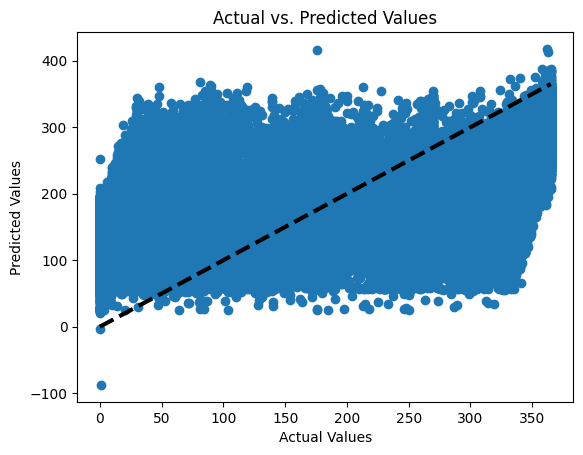

In [96]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', lw=3)  # Line for perfect predictions
plt.show()

## KNN

We will also try to build a model using KNN (k-Nearest Neighbors). As before, we are trying to predict the average profitability of each location so as to find what the most profitable location to buy a property in is. 

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score




